In [1]:
import librosa
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import os
import warnings
import IPython.display as ipd

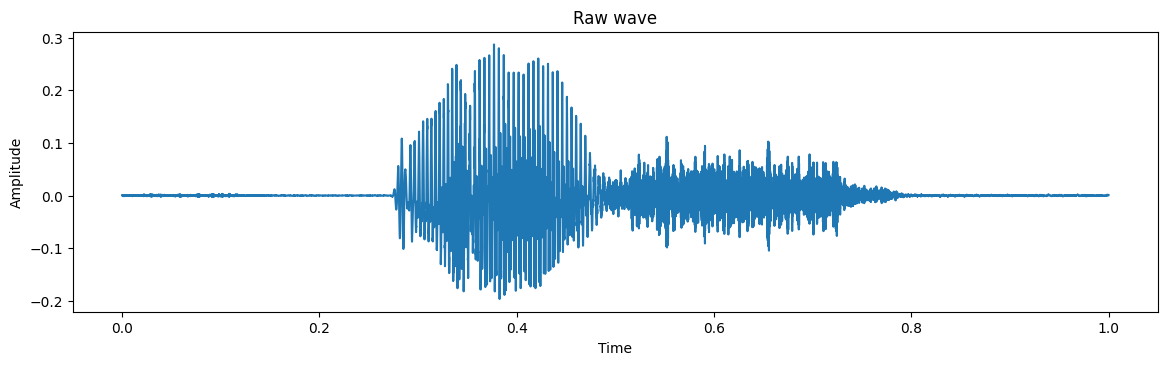

In [2]:
train_audio_path = "/home/azadm/Desktop/speech_to_text_generation/train/audio/"

samples, sample_rate = librosa.load(train_audio_path+'yes/0a7c2a8d_nohash_0.wav', sr=16000)
fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title("Raw wave")
ax1.set_xlabel("Time")
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, sample_rate/len(samples), sample_rate), samples)


In [3]:
ipd.Audio(samples, rate=sample_rate)

In [4]:
sample_rate

16000

In [5]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)

/tmp/ipykernel_74515/3105476364.py:1: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  samples = librosa.resample(samples, sample_rate, 8000)


In [6]:
labels = os.listdir(train_audio_path)

In [7]:
no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))

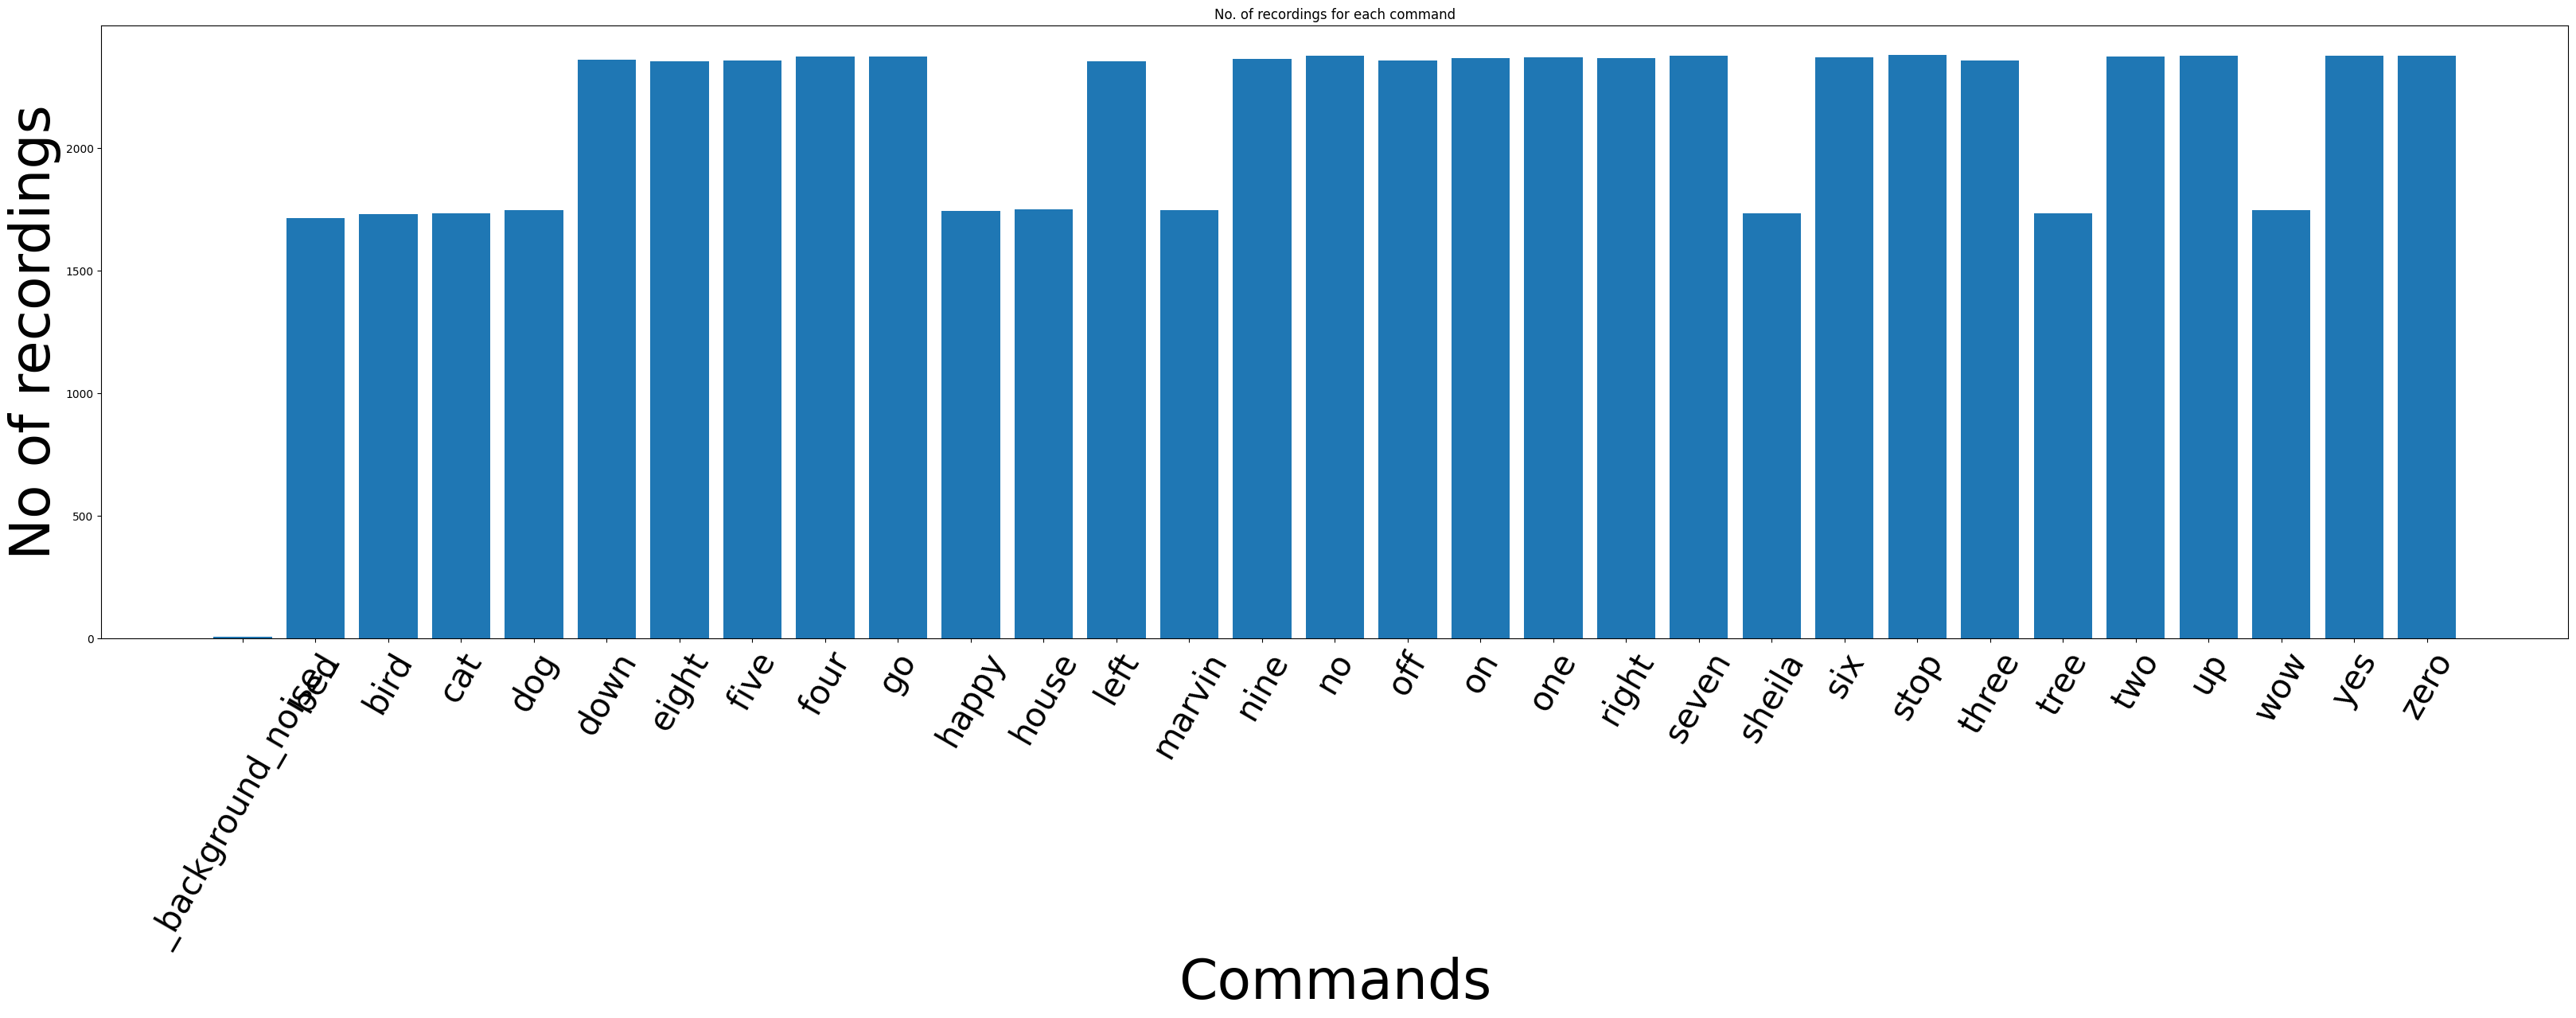

In [8]:
plt.figure(figsize=(40,10))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=50)
plt.ylabel('No of recordings', fontsize=50)
plt.xticks(index, labels, fontsize=30, rotation=60)
plt.title("No. of recordings for each command")
plt.show()

In [9]:
labels=["yes", "no", "up", "down", "left", "right", "on", "off", "stop", "go"]

In [10]:
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path+'/'+label+'/'+wav)
        duration_of_recordings.append(len(samples)/sample_rate)

(array([1.5000e+01, 3.0000e+01, 4.4000e+01, 1.3800e+02, 1.3600e+02,
        1.7900e+02, 3.6600e+02, 4.3400e+02, 5.9300e+02, 2.1747e+04]),
 array([0.418 , 0.4762, 0.5344, 0.5926, 0.6508, 0.709 , 0.7672, 0.8254,
        0.8836, 0.9418, 1.    ]),
 <BarContainer object of 10 artists>)

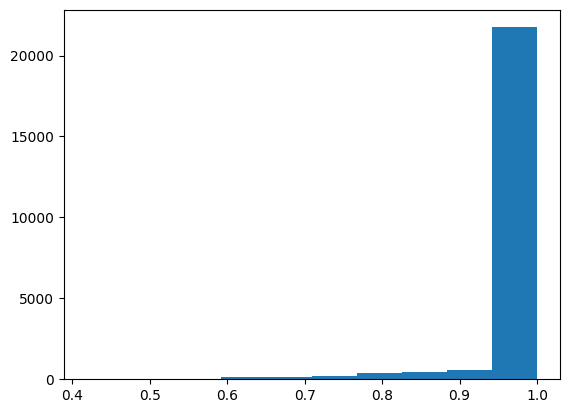

In [11]:
plt.hist(np.array(duration_of_recordings))

In [12]:
all_wave = []
all_label = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path+'/'+label) if f.endswith('.wav')]
    
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path+'/'+label+'/'+wav, sr=16000)
        samples = librosa.resample(samples, sample_rate, 8000)

        if(len(samples) == 8000):
            all_wave.append(samples)
            all_label.append(label)

yes


/tmp/ipykernel_74515/765165893.py:9: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  samples = librosa.resample(samples, sample_rate, 8000)


no
up
down
left
right
on
off
stop
go


In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_label)
classes = list(le.classes_)

In [14]:
y

array([9, 9, 9, ..., 1, 1, 1])

In [ ]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes=len(labels))

In [16]:
y.shape

(21312, 10)

In [17]:
np.array(all_wave).shape

(21312, 8000)

In [18]:
new_wave = np.array(all_wave).reshape(-1,8000,1)

In [19]:
new_wave.shape

(21312, 8000, 1)

In [20]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(new_wave, y, stratify=y, test_size=0.2, shuffle=True, random_state=777)

In [75]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPool1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape=(8000,1))

#First Conv1D layer
conv = Conv1D(8, 13, padding='valid', activation='relu', strides=1)(inputs)
conv = MaxPool1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Conv1D layer
conv = Conv1D(16, 11, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPool1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Conv1D layer
conv = Conv1D(32, 9, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPool1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Conv1D layer
conv = Conv1D(64, 7, padding='valid', activation='relu', strides=1)(conv)
conv = MaxPool1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatteen layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256, activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels), activation='softmax')(conv)


In [76]:
model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 7988, 8)           112       
                                                                 
 max_pooling1d (MaxPooling1D  (None, 2662, 8)          0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 2662, 8)           0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2652, 16)          1424      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 884, 16)          0         
 1D)                                                         

In [77]:
model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=['accuracy'])

In [79]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001)
mc = ModelCheckpoint('best_model.h5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [80]:
history = model.fit(x_tr, y_tr, epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val, y_val))

2023-01-11 01:26:59.485786: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 545568000 exceeds 10% of free system memory.


Epoch 1/100


2023-01-11 01:27:03.043009: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 21012992 exceeds 10% of free system memory.
2023-01-11 01:27:03.044827: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 21012992 exceeds 10% of free system memory.
2023-01-11 01:27:03.080959: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25228800 exceeds 10% of free system memory.
2023-01-11 01:27:03.081031: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 25228800 exceeds 10% of free system memory.


533/533 [==============================] - 121s 223ms/step - loss: 1.9599 - accuracy: 0.2695 - val_loss: 1.6675 - val_accuracy: 0.4039
Epoch 2/100
533/533 [==============================] - 124s 232ms/step - loss: 1.3808 - accuracy: 0.5104 - val_loss: 1.2232 - val_accuracy: 0.5796
Epoch 3/100
533/533 [==============================] - 117s 219ms/step - loss: 1.0766 - accuracy: 0.6261 - val_loss: 0.8871 - val_accuracy: 0.7138
Epoch 4/100
533/533 [==============================] - 118s 222ms/step - loss: 0.8946 - accuracy: 0.6948 - val_loss: 0.8234 - val_accuracy: 0.7216
Epoch 5/100
533/533 [==============================] - 116s 217ms/step - loss: 0.7781 - accuracy: 0.7356 - val_loss: 0.7209 - val_accuracy: 0.7706
Epoch 6/100
533/533 [==============================] - 118s 221ms/step - loss: 0.6732 - accuracy: 0.7687 - val_loss: 0.6708 - val_accuracy: 0.7680
Epoch 7/100
533/533 [==============================] - 118s 222ms/step - loss: 0.6280 - accuracy: 0.7870 - val_loss: 0.6230 - val_

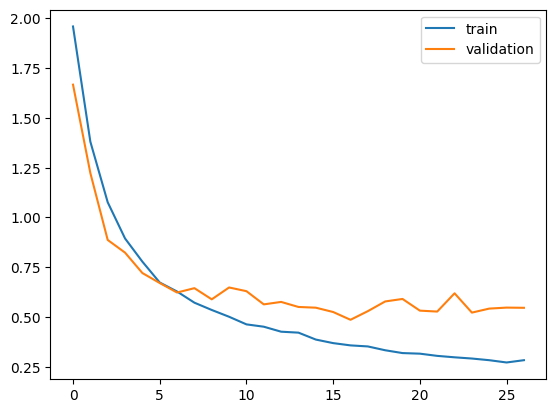

In [81]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.show()

In [21]:
from keras.models import load_model
model.save("best_model.h5")
model = load_model('best_model.h5')

2023-01-11 02:45:43.967057: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-01-11 02:45:43.967142: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-01-11 02:45:43.967179: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (azad-hplaptop15da0xxx): /proc/driver/nvidia/version does not exist
2023-01-11 02:45:43.975775: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [22]:
def prediction(audio):
    prob = model.predict(audio.reshape(1,8000,1))
    index = np.argmax(prob[0])
    return classes[index]

In [35]:
import random
index = random.randint(0, len(x_val)-1)
samples = x_val[index].ravel()
print("Audio: ",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)

Audio:  left


In [36]:
print("Text: ", prediction(samples))

1/1 [==============================] - 0s 31ms/step
Text:  left


In [60]:
import soundfile as sf
import sounddevice as sd

samplerate = 16000
duration = 1
filename = "left.wav"
print("start")
mydata = sd.rec(int(sample_rate * duration), samplerate=samplerate, channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

start
end


In [61]:
samples, sample_rate = librosa.load("left.wav", sr=16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

/tmp/ipykernel_74515/3510945455.py:2: FutureWarning: Pass orig_sr=16000, target_sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  samples = librosa.resample(samples, sample_rate, 8000)


In [62]:
prediction(samples)

1/1 [==============================] - 0s 30ms/step


'yes'